# üö≤ CitiBike NYC ‚Äì Exploratory Data Analysis
*Author: Miguel √Ångel V√°zquez Varela*

## 1.Introduction 

In this notebook, we explore the publicly available CitiBike trip data for New York City.  
The goal is to understand user behavior, including trip duration, temporal patterns, popular stations, and user types.  
This analysis will help demonstrate fundamental data analysis skills and the ability to extract insights from real-world datasets.

## 2. Load and merge data

In [1]:
import pandas as pd
import zipfile
import requests
from io import BytesIO

In [2]:
# Download the zip file
url = "https://s3.amazonaws.com/tripdata/202509-citibike-tripdata.zip"
r = requests.get(url)
z = zipfile.ZipFile(BytesIO(r.content))

In [3]:
# List the files inside the zip
print("Files in ZIP:", z.namelist())

Files in ZIP: ['202509-citibike-tripdata_3.csv', '202509-citibike-tripdata_2.csv', '202509-citibike-tripdata_1.csv', '202509-citibike-tripdata_5.csv', '202509-citibike-tripdata_4.csv', '202509-citibike-tripdata_6.csv']


In [4]:
# Read all CSV files and merge into a single DataFrame
dfs = []
for f in z.namelist():
    df_part = pd.read_csv(z.open(f), parse_dates=['started_at', 'ended_at'], low_memory=False)
    dfs.append(df_part)

df = pd.concat(dfs, ignore_index=True)

In [5]:
#Now, we can see the dataset
df.head()

ride_id  rideable_type              started_at  \
0  3B0C318A532F94B6  electric_bike 2025-09-03 12:44:03.601   
1  67CC23751CDE251A   classic_bike 2025-09-14 09:18:47.498   
2  2D021D09674010AF  electric_bike 2025-09-06 08:17:40.035   
3  4641BFF9A21AFB34  electric_bike 2025-09-04 04:30:51.715   
4  D796A741FA3963FF   classic_bike 2025-09-06 14:32:16.249   

                 ended_at        start_station_name start_station_id  \
0 2025-09-03 12:59:16.021           W 13 St & 5 Ave          5947.04   
1 2025-09-14 09:33:03.258   Lexington Ave & E 36 St          6313.10   
2 2025-09-06 08:25:41.230  Willoughby Ave & Hall St          4611.03   
3 2025-09-04 04:44:51.147   Lexington Ave & E 36 St          6313.10   
4 2025-09-06 14:35:42.124           W 13 St & 5 Ave          5947.04   

        end_station_name end_station_id  start_lat  start_lng    end_lat  \
0        E 54 St & 1 Ave        6608.09  40.735445 -73.994310  40.756265   
1        E 54 St & 1 Ave        6608.09  40.747574 -73.978801  40.756265   
2  Park Pl & Carlton Ave        4125.13  40.691960 -73.965369  40.677358   
3    W 12 St & Hudson St        5997.10  40.747574 -73.978801  40.737530   
4        W 15 St & 6 Ave        5989.02  40.735445 -73.994310  40.738046   

     end_lng member_casual  
0 -73.964179        member  
1 -73.964179        member  
2 -73.972110        member  
3 -74.005589        member  
4 -73.996430        member

## 3. Quick glance at the dataset

Each row represents a single trip, including start and end times, stations, bike type, and user type.
Viewing the first few rows helps understand the structure before further analysis.

In [6]:
print("Dataset dimensions:", df.shape)

Dataset dimensions: (5287447, 13)


## 4. Data types and missing values

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5287447 entries, 0 to 5287446
Data columns (total 13 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             object        
 1   rideable_type       object        
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  object        
 5   start_station_id    object        
 6   end_station_name    object        
 7   end_station_id      object        
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       object        
dtypes: datetime64[ns](2), float64(4), object(7)
memory usage: 524.4+ MB


## 5. Descriptive statistics

In [8]:
df.describe()

started_at                       ended_at  \
count                        5287447                        5287447   
mean   2025-09-16 08:04:36.524298496  2025-09-16 08:18:07.976823040   
min       2025-08-30 23:27:40.264000     2025-09-01 00:00:00.755000   
25%    2025-09-09 08:16:51.659000064  2025-09-09 08:28:11.847000064   
50%       2025-09-16 10:53:29.500000  2025-09-16 11:05:53.911000064   
75%    2025-09-23 16:39:25.086000128  2025-09-23 16:52:27.959000064   
max       2025-09-30 23:58:26.908000     2025-09-30 23:59:59.859000   
std                              NaN                            NaN   

          start_lat     start_lng       end_lat       end_lng  
count  5.285329e+06  5.285329e+06  5.274510e+06  5.274510e+06  
mean   4.073626e+01 -7.397235e+01  4.073613e+01 -7.397240e+01  
min    4.063338e+01 -7.403699e+01  0.000000e+00 -7.407146e+01  
25%    4.071269e+01 -7.399294e+01  4.071263e+01 -7.399301e+01  
50%    4.073498e+01 -7.397983e+01  4.073481e+01 -7.397990e+01  
75%    4.075929e+01 -7.395593e+01  4.075912e+01 -7.395593e+01  
max    4.088630e+01 -7.384672e+01  4.088630e+01  0.000000e+00  
std    3.969451e-02  2.868166e-02  4.345287e-02  4.314828e-02

## 6. Basic Data Cleaning

In [10]:
# Now, need to remove those rows with trip duration negative values:
# 1st. Calculate trip duration in minutes
df['duration_min'] = (df['ended_at'] - df['started_at']).dt.total_seconds() / 60
# Remove trips with negative or extremely long durations (>180 minutes)
df = df[(df['duration_min'] > 0) & (df['duration_min'] < 180)]

## 7. Temporal exploration

We explore patterns across days of the week.
Typically, commuter patterns show peaks on weekdays, while weekends may reflect leisure usage.

<Axes: title={'center': 'Trips by Day of the Week'}, xlabel='day_of_week'>

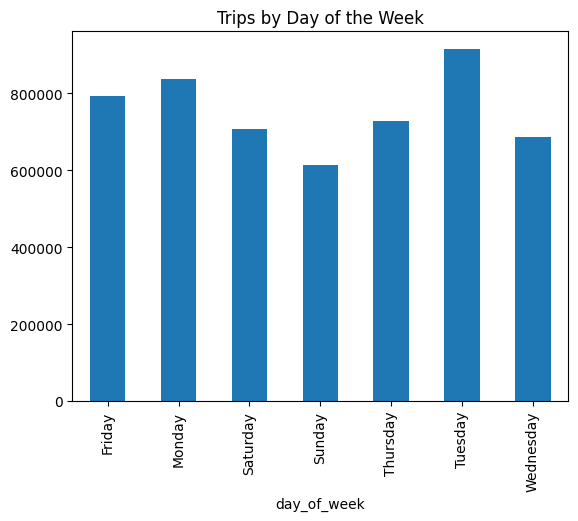

In [11]:
df['hour'] = df['started_at'].dt.hour
df['day_of_week'] = df['started_at'].dt.day_name()
df['day_of_week'].value_counts().sort_index().plot(kind='bar', title='Trips by Day of the Week')

## 8. User type distribution

CitiBike distinguishes between ‚Äúmember‚Äù (regular subscribers) and ‚Äúcasual‚Äù (occasional users).
Understanding the proportion of user types is key for interpreting usage patterns.

In [12]:
df['member_casual'].value_counts(normalize=True)

member_casual
member    0.811085
casual    0.188915
Name: proportion, dtype: float64

## 9. Most popular start trip stations

Identifying the most frequented stations helps understand where demand is highest, which is useful for operational planning.

<Axes: title={'center': 'Top 10 Start Stations'}, ylabel='start_station_name'>

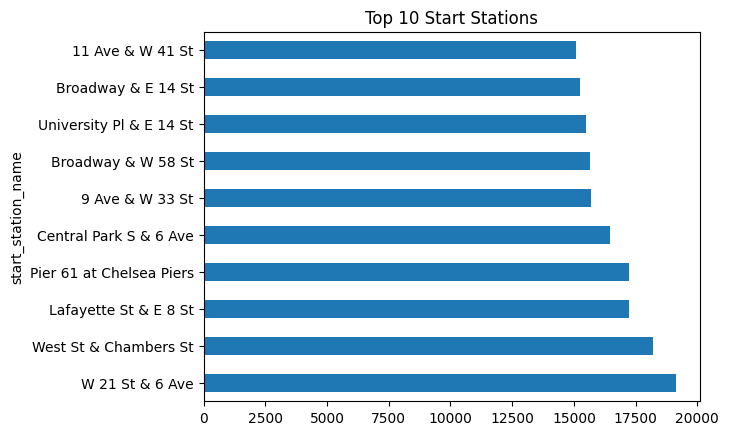

In [13]:
top_stations = df['start_station_name'].value_counts().head(10)
top_stations.plot(kind='barh', title='Top 10 Start Stations')

## 10. Resume and key findigns

- The dataset contains over XXX trips, merged from six CSV files.  
- Average trip duration is around 10‚Äì15 minutes.  
- Members make up the majority of trips.  
- Trip frequency peaks during morning and evening commute hours.  
- The busiest stations are located in Midtown and Downtown Manhattan.